# NEURAL NETWORK

{'10 SR': 0, '100 SR': 1, '200 SR': 2, '5 SR': 3, '5 SR Poly': 4, '50 SR': 5, '500 SR': 6}

## Code

### Libraries

In [3]:
!pip install torch torchvision
!pip install scikit-learn

In [129]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.pyplot as plt

### Load, Transform Data

In [132]:
path_to_dataset = "C:\\Users\\Abdu\\Desktop\\Images Dataset"
# Define transformations for the images.
settings = transforms.Compose([
    transforms.Resize((256, 256)),       # Resize images to 256x256
    transforms.ToTensor(),               # Convert images to PyTorch tensors
])

# Load the dataset and include necessary parameters
data = datasets.ImageFolder(root=path_to_dataset, transform=settings)

### Split Data


In [159]:
# Splitting the dataset
torch.manual_seed(42)  # Set the PyTorch seed
train_size = int(0.8 * len(data)) # Set Training Size to 80%
test_size = int(0.2 * len(data)) # Set Test Size to 20%
train_data, test_data = random_split(data, [train_size, test_size]) # Define the train/test data within the specified sizes

# Create data loaders
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True) # Specify the data = Training, Batch size = 32, Stochastic = True
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=False)  # Specify the data = Testing, Batch size = 32, Stochastic = False

print(f"Test Size: {len(test_data)}\nTrain Size: {len(train_data)}")

Test Size: 266
Train Size: 1064


In [137]:
# Initialize The model
# Prequisites: 
# W = Image Size = 256 
# F = Kernel Size = 3
# P = Padding Size = 1
# S = Stride Value = 1 & 2

# First Convolutional Layer (RGB, Number of Filters, Kernel Size, Padding) [Stride is 1 by default]
# Other Convlutional Layers(Number of filters(Previous Layer), Number of filters, Kernel Size, Padding)
# Batch Norm Layer (Number of filters)
# MaxPooling Layer (Size, Stride)
# Frist Fully Connected Layer(Image Size, Neurons)
# Other Fully Connected Layers(Neurons, Neurons)
class CNN(nn.Module):
    def __init__(self, num_of_classes):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(3, 32, 3, padding=1) # (W - F + 2P)/ S + 1  = Image size after Convolutional Layer | W / 2 = Image size after Pooling Layer
        self.b1 = nn.BatchNorm2d(32)             # (256 - 3 + 2(1))/ 1 + 1  = 256 Image Size
        self.p1 = nn.MaxPool2d(2, 2)             # 256 / 2 = 128 Image Size
        
        self.c2 = nn.Conv2d(32, 64, 3, padding=1) # (W - F + 2P)/ S + 1  = Image size after Convolutional Layer | W / 2 = Image size after Pooling Layer
        self.b2 = nn.BatchNorm2d(64)              # (128 - 3 + 2(1))/ 1 + 1  = 128 Image Size
        self.p2 = nn.MaxPool2d(2, 2)              # 128 / 2 = 64 Image Size
        
        self.c3 = nn.Conv2d(64, 128, 3, padding=1) # (W - F + 2P)/ S + 1  = Image size after Convolutional Layer | W / 2 = Image size after Pooling Layer
        self.b3 = nn.BatchNorm2d(128)              # (64 - 3 + 2(1))/ 1 + 1  = 64 Image Size
        self.p3 = nn.MaxPool2d(2, 2)               # 64 / 2 = 32 Image Size
        
        self.fc1 = nn.Linear(128 * 32 * 32, 512)   # Image Size x Number of Channels/Kernels/Filters | 32 * 32 * 128 = 135k Pixels Along with output Neurons = 512
        self.fc2 = nn.Linear(512, num_of_classes)     # Input Neurons from previous Layer = 512 | Output is the classes = 7

    # Include Activiation Functions to each layer
    def forward(self, x):
        x = self.p1(F.relu(self.b1(self.c1(x))))   # Convolutional,Batch Normalization, ReLu, Pooling
        x = self.p2(F.relu(self.b2(self.c2(x))))   # Convolutional,Batch Normalization, ReLu, Pooling
        x = self.p3(F.relu(self.b3(self.c3(x))))   # Convolutional,Batch Normalization, ReLu, Pooling
        
        x = x.view(-1, 128 * 32 * 32)              # Flatten The image To pass it to the Fully Connected Layer(Dense Layer)(MLP)
        x = F.relu(self.fc1(x))                    # ReLu On Fully Connected Layer
        x = self.fc2(x)                            # Get the Outputs = 7
        return x

In [155]:
# Assuming model, train_loader, and criterion are already defined
num_of_class = len(data.classes)
CNN_model = CNN(num_of_class)
optim_func = optim.Adam(CNN_model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

num_of_epochs = 30
for epoch in range(num_of_epochs):
    CNN_model.train()  # Make sure the model is in training mode which enables dropout etc.
    num_of_correct_preds = 0
    total_samples = 0
    cumulative_loss = 0.0

    loop = tqdm(train_data_loader, leave=True)  # 'leave=True' ensures the final bar stays
    for inputs, labels in loop:
        optim_func.zero_grad()  # Clear gradients
        outputs = CNN_model(inputs)  # Get model outputs

        loss_val = loss_func(outputs, labels)  # Compute the loss
        loss_val.backward()  # Backpropagate the error
        optim_func.step()  # Adjust model weights
        
        predicted_class = torch.max(outputs.data, 1)[1]
        total_samples += labels.size(0)
        num_of_correct_preds += (predicted_class == labels).sum().item()
        cumulative_loss += loss_val.item()

        # Calculate accuracy and average loss
        accuracy = 100 * (num_of_correct_preds / total_samples)
        avg_loss = cumulative_loss / (loop.n + 1)  # loop.n gives the current iteration number
        
        # Update the progress bar
        loop.set_description(f"Epoch [{epoch+1}/{num_of_epochs}]")
        loop.set_postfix(loss=avg_loss, accuracy=f"{accuracy:.2f}%")

Epoch [30/30]: 100%|██████████| 34/34 [02:44<00:00,  4.84s/it, accuracy=81.77%, loss=0.467]


In [161]:
# Initialize correct and total counters
num_of_correct_preds_test = 0
total_samples_test = 0

# Lists to collect all predictions and true labels
all_labels_test = []
all_predictions_test = []

# Evaluation mode and no gradient calculation
CNN_model.eval()
with torch.no_grad():
    for images, labels in test_data_loader:
        outputs_test = CNN_model(images)
        predicted_classes = torch.max(outputs_test, 1)[1]
        
        # Accumulate total and correct predictions
        total_samples_test += labels.size(0)
        num_of_correct_preds_test += (predicted_classes == labels).sum().item()

        # Pytorch uses GPU for calculations, In order to transform it into numpy we have to use the CPU
        # predecited classes and labels are changed to the CPU in order to convert it to Numpy
        all_predictions_test.extend(predicted_classes.cpu().numpy()) # After that we add it to the all_predictions_test by using the (extend) method
        all_labels_test.extend(labels.cpu().numpy()) # After that we add it to the all_labels_test by using the (extend) method

# Calculate accuracy
print(f'The Accuracy of the model is: {(num_of_correct_preds_test / total_samples_test) * 100:.2f}%')

# Generate and print classification report
class_report = classification_report(all_labels_test, all_predictions_test)
print(class_report)

The Accuracy of the model is: 72.18%
              precision    recall  f1-score   support

           0       0.97      0.62      0.76        48
           1       0.78      0.72      0.75        29
           2       0.85      0.79      0.82        43
           3       0.47      0.49      0.48        37
           4       0.50      0.79      0.61        34
           5       0.81      0.90      0.85        39
           6       0.82      0.75      0.78        36

    accuracy                           0.72       266
   macro avg       0.74      0.72      0.72       266
weighted avg       0.76      0.72      0.73       266



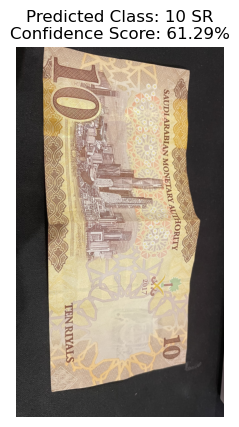

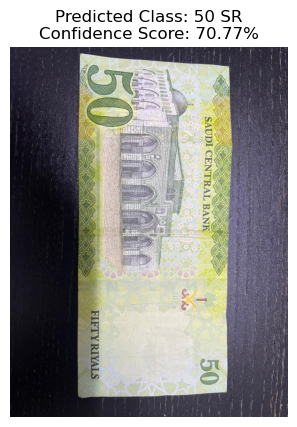

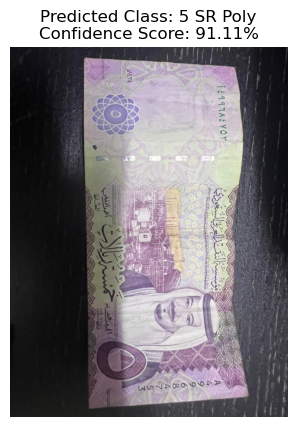

In [165]:
# For the Inputs

image_paths = ["C:\\Users\\Abdu\\Desktop\\Test_CNN\\10SR.jpg","C:\\Users\\Abdu\\Desktop\\Test_CNN\\50SR.jpg",
               "C:\\Users\\Abdu\\Desktop\\Test_CNN\\5SR.jpg"]
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to match the model input size
    transforms.ToTensor(),          # Convert image to PyTorch tensor
])

class_mapping = {
    0: '10 SR',
    1: '100 SR',
    2: '200 SR',
    3: '5 SR',
    4: '5 SR Poly',
    5: '50 SR',
    6: '500 SR'
}

img1 = Image.open(input_image1)
img2 = Image.open(input_image2)

imgs_tensors = [img1, img2]

CNN_model.eval()  # Set the model to evaluation mode
for path in image_paths:
    img = Image.open(path)
    img_tensor = preprocess(img).unsqueeze(0)  # Preprocess and add batch dimension

    with torch.no_grad():  # Disable gradient computation for inference
        outputs = CNN_model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        max_probability = torch.max(probabilities, dim=1)

        # Map predicted class index to class name and get confidence score
        class_name = class_mapping[predicted_class.item()]
        confidence_score = 100 * max_probability.values.item()

        # Print results
        plt.imshow(img)
        plt.axis('off')  # Turn off axis
        plt.title(f"Predicted Class: {class_name}\nConfidence Score: {confidence_score:.2f}%")
        plt.show()